# Train on Conditional PMFs P(m|n)


First, load in modules.

In [12]:
import numpy as np
import time
from scipy import stats


import torch
import train_conditional as trc
import tools_conditional as ttc

Next, load in data. Data for conditional PMF training is stored in : 

1. '/home/mcarilli/CME/conditional_training_data'


'Parameter' vectors are stored as {$\textrm{log}_{10}(b), \textrm{log}_{10}(\beta),\textrm{log}_{10}(\gamma),n$},
where $n$ is the nascent RNA count at which to calculate the conditional distribution P(m|n).

In [13]:
path = '/home/mcarilli/CME/conditional_training_data/'

In [14]:
train_list,test_list = trc.get_file_paths(set_size = 256,
                                number_of_training_files=2,
                                 number_of_testing_files=1,total_files=5,file_path=path)

Calculating ypred at runtime! 

In [15]:
npdf = 10

def get_NORM(npdf,quantiles='lin'):
    if quantiles == 'lin':
        q = np.linspace(0,1,npdf+2)[1:-1]
        NORM = stats.norm.ppf(q)
        NORM = torch.tensor(NORM)
        return NORM
    if quantiles == 'cheb':
        q = np.linspace(0,1,npdf+2)[1:-1]
        NORM = stats.norm.ppf(q)
        NORM = torch.tensor(NORM)
        return NORM

def generate_grid(npdf,VAR,MU):
    logstd = torch.sqrt(np.log((VAR/MU**2)+1))
    logmean = torch.log(MU**2/np.sqrt(VAR+MU**2))
    translin = torch.exp(logmean+logstd*NORM)
    return(translin)


def get_ypred_at_RT(p,w,hyp,npdf=npdf):
    '''Given a parameter vector (tensor) and weights (tensor), and hyperparameter,
    calculates ypred (Y) at runtime.'''
    
    n = p[3]
    p_vec = 10**p[:-1]
    
    # mean, variance, standard deviation of exact (2D) solution
    MU, VAR, STD, xmax = trc.get_moments(p_vec)
    
    # unpack mean, variance, STD for nascent and mature RNA 
    MU_n,MU_m,VAR_n,VAR_m,STD_n,STD_m,xmax_n,xmax_m = MU[0],MU[1],VAR[0],VAR[1],STD[0],STD[1],xmax[0],xmax[1]

    tau = 2. # correlation between lognormal of nascent and lognormal of mature
    
    # mean and variance for mature conditionals, mc, P(m|n), which are lognormally distributed 
    # should I exponentiate these? 
    MU_mc = MU_m + tau * (STD_m/STD_n) * ( torch.log(n) - MU_n) 
    VAR_mc = STD_m**2 * (1 - tau**2 )
    
    # generate the grid based on the moments of the conditional lognormals
    grid = generate_grid(npdf,VAR_mc,MU_mc)
    
    s = torch.zeros(npdf)
    s[0] = grid[0]
    s[1:] = torch.diff(grid)
    
    s *= hyp
    
    r = (grid/s)**2 
    p = 1/(1+s**2/grid)
    xgrid = torch.arange(xmax_m+1)
    Y = torch.zeros(xmax_m+1)
    GAMMALN_XGRID = lnfactorial[1:len(xgrid)+1]

    for i in range(npdf):
        l = torch.special.gammaln(xgrid+r[i]) - GAMMALN_XGRID - torch.special.gammaln(r[i]) + xgrid*torch.log(1-p[i]) + r[i]*torch.log(p[i])
    
        Y += w[i]*torch.exp(l)
    return Y


Define NORM quantiles and lnfactorial.

In [16]:
NORM = get_NORM(npdf)

# precalculate lngammas
lnfactorial = torch.special.gammaln(torch.arange(1003))

For cleaner training, set up model configurations and training configurations to pass to train. 

Model is 2 hidden layers, with user-defined dimensions.

Input dimension is 4 ('param vector' and n value), and output is npdf.

In [17]:
model_config = {
    'npdf' : 10,
    'h1_dim' : 256,
    'h2_dim' : 128,
    'norm_type' : 'softmax',
}

train_config = {
    'num_epochs' : 20,
    'lr' : 1e-3,
    'batchsize' : 1,
    'metric' : 'kld',
}

norm_type options:
    1. 'softmax'
    2. 'normalize' (applies sigmoid so all are positive, then normalizes)
    3. None (takes absolute value of output weights)
   
metric options:
    1. 'kld'
    2. 'kld_normalized'
    3. 'totalse'
    4. 'mse'
    5. 'maxabsdev'
    6. 'maxabsdevlog'
    7. 'mselog'
    

## And Train

In [18]:
t1 = time.time()
e,t,model = trc.train(train_list[200:210],test_list[0:10],model_config,train_config,get_ypred_at_RT)
t2 = time.time()

print(t2-t1)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3


/home/mcarilli/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-15-5f52931e7405>:16: RuntimeWarning: invalid value encountered in log
  logstd = torch.sqrt(np.log((VAR/MU**2)+1))
<ipython-input-15-5f52931e7405>:17: RuntimeWarning: invalid value encountered in sqrt
  logmean = torch.log(MU**2/np.sqrt(VAR+MU**2))


Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
Epoch Number: 10
Epoch Number: 11
Epoch Number: 12
Epoch Number: 13
Epoch Number: 14
Epoch Number: 15
Epoch Number: 16
Epoch Number: 17
Epoch Number: 18
Epoch Number: 19
1.2105281352996826


-----

## Validation and Plotting

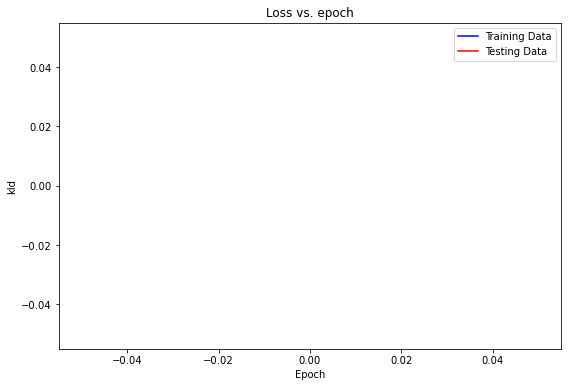

In [20]:
ttc.plot_training(e,t,metric='kld')

In [28]:
metrics,metric_mean = trc.calculate_test_metrics(test_list,model,get_ypred_at_RT,metric)

NameError: name 'metric' is not defined

In [29]:
ttc.plot_CDF(metrics)

NameError: name 'metrics' is not defined

In [9]:
ttc.plot_histogram(array,bins,metric='kld')

NameError: name 'ttc' is not defined

In [31]:
ttc.plot_PMF_grid(data_list,npdf,nrows,ncols,model,get_ypred_at_RT,kld=True)

NameError: name 'data_list' is not defined

In [32]:
ttc.plot_param_quantiles(klds=metrics,train_list=test_list,model=model)

NameError: name 'metrics' is not defined